In [1]:
from src.hyperparameter_tuner import *
from src.model_evaluation import *
from src.viz_and_model_analysis import *
from src.shap_visualizer import *

In [2]:
from sklearn.preprocessing import RobustScaler, StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.calibration import CalibratedClassifierCV

from imblearn.pipeline import Pipeline

from imblearn.over_sampling import ADASYN, SMOTE

import catboost as cb
import lightgbm as lgb
import xgboost as xgb

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns


import pandas as pd

custom_palette = {
    'Fraud': '#c53b53',
    'Non-Fraud': '#394b70'
}
sns.color_palette(list(custom_palette.values()))

[(0.7725490196078432, 0.23137254901960785, 0.3254901960784314),
 (0.2235294117647059, 0.29411764705882354, 0.4392156862745098)]

In [4]:
df_raw = pd.read_parquet('data/creditcard.parquet')

In [5]:
df_analysis = df_raw.copy()
df_analysis

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [6]:
df_analysis.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [7]:
df_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [8]:
df_analysis.isnull().sum().max()

np.int64(0)

In [9]:
df_analysis.duplicated().sum().max()

np.int64(1081)

In [10]:
duplicadas = df_analysis[df_analysis.duplicated()]

duplicadas.groupby(list(df_analysis.columns)).size().reset_index(name='count').query('count > 1')
duplicadas.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
33,26.0,-0.529912,0.873892,1.347247,0.145457,0.414209,0.100223,0.711206,0.176066,-0.286717,...,0.046949,0.208105,-0.185548,0.001031,0.098816,-0.552904,-0.073288,0.023307,6.14,0
35,26.0,-0.535388,0.865268,1.351076,0.147575,0.433680,0.086983,0.693039,0.179742,-0.285642,...,0.049526,0.206537,-0.187108,0.000753,0.098117,-0.553471,-0.078306,0.025427,1.77,0
113,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
114,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
115,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0


In [11]:
# df = df.drop_duplicates()

In [12]:
class_label = {
    0: 'Non-Fraud', 
    1: 'Fraud'
}

df_analysis['Class_label'] = df_analysis['Class'].map(class_label)

In [13]:
# category_col='Class_label'

# visualizer = DataVisualizer(
#     dataframe=df_analysis, 
#     figsize=(4, 4), 
#     title = f'Credit Fraud'
#     )

# visualizer.plot_categorical_distribution(
#     category_col=category_col, 
#     palette = custom_palette
#     )

In [14]:
df_analysis['Amount_log'] = np.log1p(df_analysis['Amount'])

In [15]:
# visualizer = DataVisualizer(
#     dataframe=df_analysis, 
#     figsize=(12, 4), 
#     # title = f'Credit Fraud'
#     )

# visualizer.plot_feature_histograms(
#     feature_cols=['Time', 'Amount_log'],
#     group_col = 'Class_label',
#     palette = custom_palette,
#     common_norm=False,
#     stat='density',
#     kde=True,
# )

In [16]:
df_corr = df_analysis.drop(['Class_label'], axis=1)
corr = df_corr.corr()

In [17]:
# # Create a masked heatmap
# plt.figure(figsize=(12, 10))
# # plt.rcParams.update({'font.size': 12})
# sns.heatmap(corr, cmap = 'coolwarm', center = 0, linewidths=.1)
# plt.show()

In [18]:
corr['Class'][corr['Class'] < -0.13]

V3    -0.192961
V7    -0.187257
V10   -0.216883
V12   -0.260593
V14   -0.302544
V16   -0.196539
V17   -0.326481
Name: Class, dtype: float64

In [19]:
corr['Class'][corr['Class'] > 0.13]

V4       0.133447
V11      0.154876
Class    1.000000
Name: Class, dtype: float64

In [20]:
# visualizer = DataVisualizer(
#     dataframe=df_analysis, 
#     figsize=(12, 6), 
#     # title = f'Credit Fraud'
#     )

# visualizer.plot_feature_boxplots(
#     feature_cols=['V3', 'V4','V7', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17'],
#     group_col = 'Class_label',
#     palette = custom_palette,
# )

In [21]:
# visualizer = DataVisualizer(
#     dataframe=df_analysis, 
#     figsize=(12, 8), 
#     # title = f'Credit Fraud'
#     )

# visualizer.plot_feature_histograms(
#     feature_cols=['V3', 'V4', 'V7', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17'],
#     group_col = 'Class_label',
#     palette = custom_palette,
#     common_norm=False,
#     stat='density',
#     kde=True,
# )

---

# feature Engineering

In [22]:
# robust_scaler = RobustScaler()

# df['scaled_amount'] = robust_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
# df['scaled_time'] = robust_scaler.fit_transform(df['Time'].values.reshape(-1,1))

In [23]:
# features = ['Time', 'Amount']

# poly = PolynomialFeatures(degree=2, include_bias=False)
# poly_features = poly.fit_transform(df[features])

# poly_column_names = [f"{col}_poly" for col in poly.get_feature_names_out(features)]

# df_poly = pd.DataFrame(poly_features, columns=poly_column_names)
# # df_feature = pd.concat([df_feature, df_poly.drop(['Age', 'Balance'], axis=1)], axis=1)
# df = pd.concat([df, df_poly], axis=1)
# df_poly

In [24]:
# scaler = StandardScaler()

# df[poly_column_names] = scaler.fit_transform(df[poly_column_names])

In [25]:
features = ['V3', 'V4','V7', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17']

poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df_analysis[features])

poly_column_names = [f"{col}_poly" for col in poly.get_feature_names_out(features)]

df_poly = pd.DataFrame(poly_features, columns=poly_column_names)

scaler = StandardScaler()

df_poly[poly_column_names] = scaler.fit_transform(df_poly[poly_column_names])

df_analysis = pd.concat([df_analysis, df_poly], axis=1)
# df_poly

In [26]:
scaler = StandardScaler()

df_poly[poly_column_names] = scaler.fit_transform(df_poly[poly_column_names])

df_analysis = pd.concat([df_analysis, df_poly], axis=1)
# df_poly

In [27]:
# minmaxscaler = MinMaxScaler()

# scaler = MinMaxScaler()
# scaled = scaler.fit_transform(df[['Time', 'Amount']])

# df[['time_minmax', 'amount_minmax']] = scaled

In [28]:
features_drop = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 
 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 
 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class_label']

In [29]:
df_corr = df_analysis.drop(features_drop, axis=1)
corr = df_corr.corr()

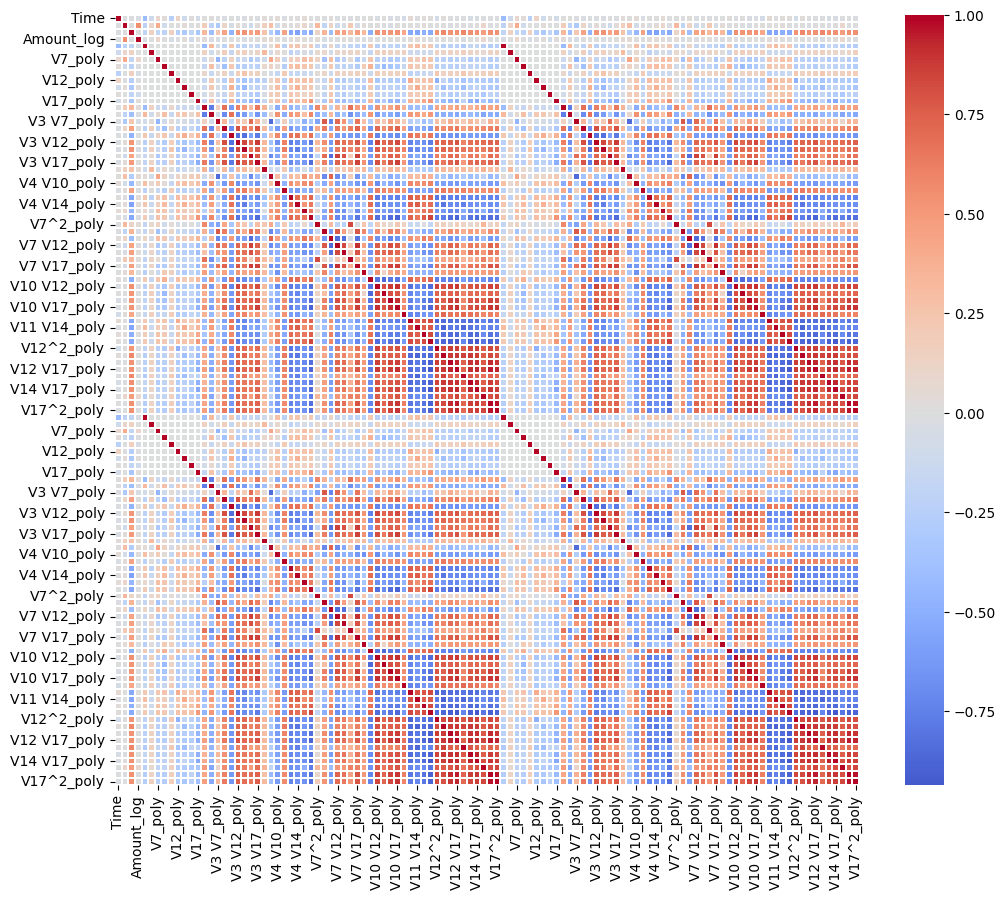

In [30]:
plt.figure(figsize=(12, 10))

sns.heatmap(corr, cmap = 'coolwarm', center = 0, linewidths=.1)
plt.show()

---

In [31]:
from scipy.stats import zscore
z_scores = zscore(df_analysis['Amount'])
outliers = df_analysis[abs(z_scores) > 3]
len(outliers)

4076

In [32]:
Q1 = df_analysis['Amount'].quantile(0.25)
Q3 = df_analysis['Amount'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_analysis[(df_analysis['Amount'] < lower_bound) | (df_analysis['Amount'] > upper_bound)]
len(outliers)

31904

In [33]:
# df['Hour'] = (df['Time'] // 3600) % 24


In [34]:
# df['Day'] = df['Time'] // (3600 * 24)

In [35]:
# def time_bin(hour):
#     if 0 <= hour < 6:
#         return 'madrugada'
#     elif 6 <= hour < 12:
#         return 'manhã'
#     elif 12 <= hour < 18:
#         return 'tarde'
#     else:
#         return 'noite'

# df['Time_bin'] = df['Hour'].apply(time_bin)

In [36]:
# mapa = {
#     'madrugada': 0,
#     'manhã': 1,
#     'tarde': 2,
#     'noite': 3
# }
# df['Time_bin_encoded'] = df['Time_bin'].map(mapa)

In [37]:
# df['Is_night'] = df['Hour'].apply(lambda x: 1 if x < 6 else 0)

In [38]:
X = df_analysis.drop(['Class'], axis=1)
y = df_analysis['Class']

In [39]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [40]:
# tuner = ClassificationHyperTuner(
#     X_train=X_train, 
#     y_train=y_train, 
#     X_test=X_test,
#     y_test=y_test, 
#     model_name='xgb', 
#     use_cv=True, 
#     use_smote=True,
# )

# best_params_xgb, best_value_xgb = tuner.run_optimization()

In [41]:
params ={
'learning_rate': 0.0017987581966647005,
'n_estimators': 1054,
'max_depth': 6,
'min_child_weight': 5,
'subsample': 0.9205211904238673,
'colsample_bytree': 0.5817550861508812,
'gamma': 2.025384196298485,
'lambda': 0.2576838772671989,
'alpha': 0.033825003305923404,
'scale_pos_weight': 0.6814876076278935,
"eval_metric": "aucpr",
"tree_method": "hist",
"random_state": 42,
"objective": "binary:logistic",
"verbosity": 0
}

In [42]:
params ={
"eval_metric": "aucpr",
"tree_method": "hist",
"random_state": 42,
"objective": "binary:logistic",
"verbosity": 0
    }

sampling_strategy = 0.1

features = ['V3', 'V4','V7', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17']

In [43]:
poly_scaler_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('poly_scaling', poly_scaler_pipeline, features)
], remainder='passthrough') #

In [44]:
xgb_calibrated = CalibratedClassifierCV(
    estimator=xgb.XGBClassifier(**params),
    method='sigmoid',
    cv=3
)

In [45]:
pipeline_final = ImbPipeline([
    ('preprocessing', preprocessor),
    # ('smote', SMOTE(sampling_strategy=sampling_strategy, random_state=42)),
    # ('model', xgb_calibrated),
    ('model', xgb.XGBClassifier(**params))
])

In [46]:
# train_xgb = ClassificationEvaluator(model=pipeline_final)

# cv_scores_xgb, X_train_cv, y_cv, y_pred_cv, y_proba_cv = train_xgb.cross_validate(X=X, y=y)
# cv_scores_xgb

In [47]:
# plotter = ClassificationPlotter(
#     true_labels=y_cv,
#     predicted_labels=y_pred_cv,
#     predicted_probabilities=y_proba_cv,
#     features=X_train_cv,
#     model=pipeline_final
# )

In [48]:
# plotter.plot_selected_charts(
#     charts = [
#         'confusion_matrix',
#         'roc_curve',
#         'precision_recall_curve',
#         'probability_distribution',
#         'calibration_curve'
#     ]
# )

In [49]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras.metrics import AUC, Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

2025-05-08 12:10:35.782450: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-08 12:10:35.787743: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-08 12:10:35.796047: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746717035.814056 2166029 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746717035.818308 2166029 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746717035.834854 2166029 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [50]:
# df_analysis = df_analysis.drop(['Class_label'], axis=1)

In [51]:
# import numpy as np
# import pandas as pd

# def df_to_lstm_supervised(df: pd.DataFrame, window: int, target_col: str):
#     X, y = [], []
#     df_values = df.values
#     target_idx = df.columns.get_loc(target_col)

#     for i in range(window, len(df)):
#         window_data = df_values[i - window:i, :]
#         X.append(window_data)
#         y.append(df_values[i, target_idx])

#     X = np.array(X)  # shape: (n_samples, window, n_features)
#     y = np.array(y)  # shape: (n_samples,)
#     return X, y

# window = 300
# df_raw = df_raw.astype('float32')
# X, y = df_to_lstm_supervised(df_raw, window, target_col='Class')
# # X = X.astype('float32')
# # y = y.astype('float32')
# split_idx = int(len(X) * 0.8)
# X_train, y_train = X[:split_idx], y[:split_idx]
# X_test, y_test = X[split_idx:], y[split_idx:]

In [70]:
def make_dataset(df: pd.DataFrame, window: int, target_col: str, batch_size: int = 64):
    target_idx = df.columns.get_loc(target_col)
    df_values = df.values.astype('float32')

    def generator():
        for i in range(window, len(df)):
            X_window = df_values[i - window:i, :]
            y_target = df_values[i, target_idx]
            yield X_window, y_target

    ds = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(window, df.shape[1]), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.float32)
        )
    )
    ds = ds.shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

window = 300
batch_size = 64
# Crie datasets diretamente
split_idx = int(len(df_raw) * 0.8)
df_train = df_raw.iloc[:split_idx].copy()
df_test = df_raw.iloc[split_idx - window:].copy()  # inclui janela anterior

train_ds = make_dataset(df_train, window=300, target_col='Class', batch_size=batch_size)
test_ds = make_dataset(df_test, window=300, target_col='Class', batch_size=batch_size)


In [71]:
import tensorflow as tf
from tensorflow.keras import backend as K

def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_true = K.cast(y_true, tf.float32)
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        pt = tf.where(K.equal(y_true, 1.0), y_pred, 1.0 - y_pred)
        loss_val = -alpha * K.pow(1.0 - pt, gamma) * K.log(pt)
        return K.mean(loss_val)
    return loss

In [76]:
model = Sequential([
    Input(shape=(window, 31)),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=focal_loss(gamma=2., alpha=0.95),
    metrics=[AUC(name='roc_auc'), Precision(), Recall()]
)

In [77]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_roc_auc',
    mode='max',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)


In [78]:
# from sklearn.utils import class_weight
# import numpy as np

# weights = class_weight.compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(y_train),
#     y=y_train
# )
# class_weights = dict(enumerate(weights))

In [79]:
model.fit(
    train_ds,
    validation_data=test_ds,
    # steps_per_epoch = (len(df_train) - window) // batch_size,
    # validation_steps=(len(df_test) - window) // batch_size,
    steps_per_epoch=500,         # reduz para terminar em ~1 min
    validation_steps=100,
    epochs=1,
    callbacks=[early_stop, checkpoint]
)

500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 0.0381 - precision_5: 0.0062 - recall_5: 0.0821 - roc_auc: 0.5243
Epoch 1: val_roc_auc improved from -inf to 0.50000, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 146s 285ms/step - loss: 0.0381 - precision_5: 0.0062 - recall_5: 0.0819 - roc_auc: 0.5244 - val_loss: 0.0046 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - val_roc_auc: 0.5000
